In [ ]:
import torch
import pickle
import graph_generation
import numpy as np

In [ ]:
graphs, metadata = graph_generation.community_sbm.load_community_dataset("data/community_sbm/params_2_30_0.8_0.02_8/graphs.pkl")

In [ ]:
nodes_in_community = [torch.sum(g.node_features[:,0]) for g in graphs ]

In [ ]:
nodes_in_community

[tensor(19.),
 tensor(12.),
 tensor(10.),
 tensor(13.),
 tensor(15.),
 tensor(18.),
 tensor(17.),
 tensor(8.),
 tensor(18.),
 tensor(12.),
 tensor(8.),
 tensor(18.),
 tensor(11.),
 tensor(8.),
 tensor(11.),
 tensor(20.),
 tensor(20.),
 tensor(12.),
 tensor(11.),
 tensor(14.),
 tensor(21.),
 tensor(17.),
 tensor(13.),
 tensor(18.),
 tensor(18.),
 tensor(19.),
 tensor(14.),
 tensor(9.),
 tensor(20.),
 tensor(10.),
 tensor(20.),
 tensor(19.),
 tensor(20.),
 tensor(8.),
 tensor(19.),
 tensor(16.),
 tensor(11.),
 tensor(13.),
 tensor(14.),
 tensor(16.),
 tensor(18.),
 tensor(18.),
 tensor(10.),
 tensor(11.),
 tensor(9.),
 tensor(17.),
 tensor(20.),
 tensor(9.),
 tensor(14.),
 tensor(14.),
 tensor(13.),
 tensor(17.),
 tensor(14.),
 tensor(8.),
 tensor(9.),
 tensor(18.),
 tensor(17.),
 tensor(15.),
 tensor(21.),
 tensor(12.),
 tensor(17.),
 tensor(12.),
 tensor(14.),
 tensor(21.),
 tensor(19.),
 tensor(10.),
 tensor(8.),
 tensor(20.),
 tensor(19.),
 tensor(19.),
 tensor(21.),
 tensor(13.),
 t

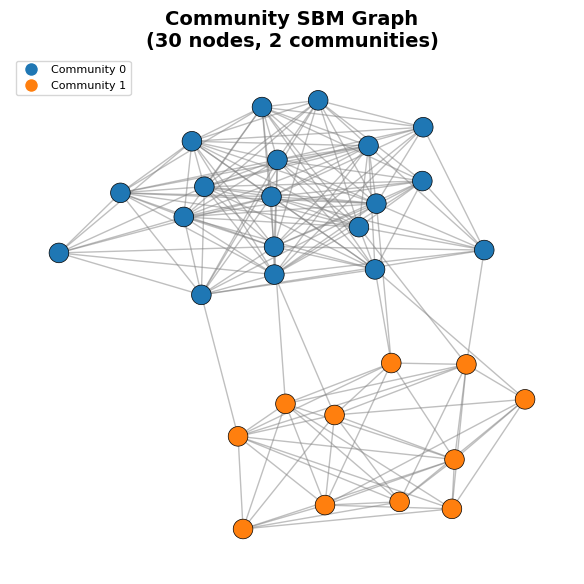

In [ ]:
_ = graph_generation.visualization.show_community_graph(graphs[0])

In [ ]:
import os
import time
import pickle
import numpy as np
import torch
from tqdm import tqdm

from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.samplers import MHSamplerFeatures, GraphTuple, ChimeraSamplerFeatures

def basic_observables(graph_tuple: GraphTuple) -> torch.Tensor:

    mtx = graph_tuple.adj
    feat = graph_tuple.node_features

    nn = torch.sum(feat,axis=0)
    mm = (feat.T) @ mtx @ feat
    #val = 10 * mm[0,0]/torch.sum(feat, axis = 0)[0]
    mm = mm / nn
    mm = mm.ravel()
    edges = torch.sum(mtx) / 2
    triangles = torch.trace(mtx @ mtx @ mtx) / 6
    #return torch.stack([mm[0], mm[1], mm[2], mm[3], edges, triangles])
    return torch.stack([nn[0], nn[1], mm[0]* mm[3], -mm[1] * mm[2], edges, triangles])

#class MySampler(MHSamplerFeatures):
class MySampler(ChimeraSamplerFeatures):
    def __init__(self, p_edge = 0.8, backend = "cpu"):
        super().__init__(p_edge = p_edge, backend = backend)
    def observables(self, graph_tuple): 
        return basic_observables(graph_tuple)


In [ ]:
basic_observables(graphs[0])

tensor([ 1.9000e+01,  1.1000e+01,  1.0122e+02, -3.0622e-01,  1.7400e+02,
         4.4500e+02])

In [ ]:

sampler = MySampler()

In [ ]:

graph = graphs[0]
obs   = sampler.observables(graph)
params = torch.Tensor([0., 0., 0., 0., 0., 0.])
niter  = 1000000
params_update_every = 5
save_every = 250
alpha = 0.0002
min_change = 0.001
tot_accept = 1000000

params_hist, graph_hist = sampler.param_run(
    graph=graph,
    observables=obs,
    params=params,
    niter=niter,
    params_update_every=params_update_every,
    save_every=save_every,
    save_params=True,
    alpha=alpha,
    min_change=min_change,
    tot_accept=tot_accept,
    verbose_level=0
)

params_final = params_hist[-1]
print(params_final)

return_obs, return_graph = sampler.sample_run(
    graph=graph,
    params=params_final,
    niter=100000,
    save_every=save_every,
    burn_in=0.3
)

final_params = params_hist[-1]

# sampler.param_run already prints accepted/rejected
# but we try to extract them from attributes if present
accepted = getattr(sampler, "accepted_steps", None)
rejected = getattr(sampler, "rejected_samples", None)
acc_rate = (accepted / niter) if accepted is not None else None


  0%|          | 0/1000000 [00:00<?, ?it/s]


NameError: name 'params' is not defined

<Figure size 640x480 with 0 Axes>

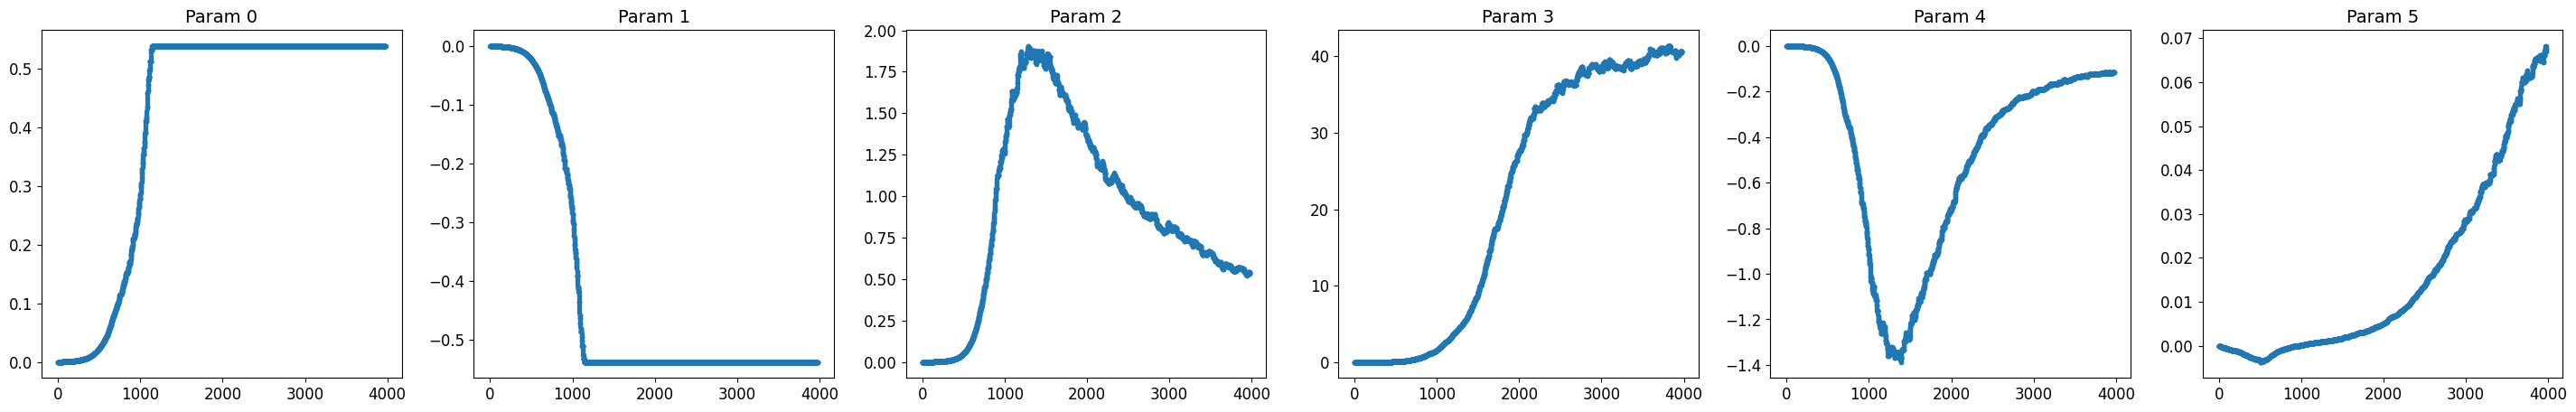

In [ ]:

import matplotlib.pyplot as plt

pp = torch.stack(params_hist).numpy()
n_params = pp.shape[1]
height = 5
width = 6
plt.tight_layout()
plt.figure(figsize = (width * n_params, height))

for i in range(n_params):
    plt.subplot(1,n_params, i + 1)
    plt.title(f"Param {i}")
    plt.plot(pp[:,i], ".-")


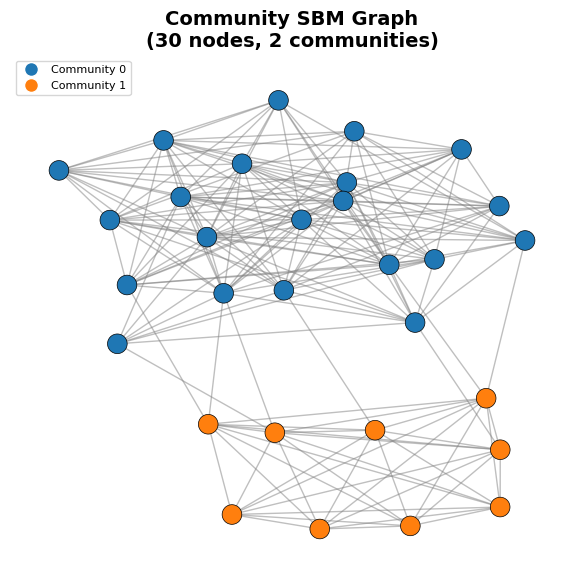

In [ ]:
_ = graph_generation.visualization.show_community_graph(return_graph[-2])